In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import timedelta
from sklearn.decomposition import PCA
import haversine

In [3]:
train = pd.read_csv('C:\\scnguh\\datamining\\NYC taxi trip duration\\train.csv')
test = pd.read_csv('C:\\scnguh\\datamining\\NYC taxi trip duration\\test.csv')

In [4]:
# clean data
train = train.drop('dropoff_datetime', 1)

In [7]:
# Values are in minutes
print(np.percentile(train.trip_duration, 99) / 60)
print(np.percentile(train.trip_duration, 99.5) / 60)
print(np.percentile(train.trip_duration, 99.6) / 60)
print(np.percentile(train.trip_duration, 99.8) / 60)
print(np.percentile(train.trip_duration, 99.85) / 60)
print(np.percentile(train.trip_duration, 99.9) / 60)
print(np.percentile(train.trip_duration, 99.99) / 60)
print(np.percentile(train.trip_duration, 99.999) / 60)
print(np.percentile(train.trip_duration, 99.9999) / 60)
print(train.trip_duration.max() / 60)

57.333333333333336
68.98333333333333
73.38333333333334
92.52856666666533
134.02494999999956
1418.8059500000013
1438.7833333333333
1439.4833333333333
35765.9658686484
58771.36666666667


In [9]:
# Check how many trips remain with each limit
print('-----------')
print(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.9)]))
print(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.99)]))
print(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.999)]))

-----------
1457185
1458505
1458630


In [10]:
# Remove outliers
train = train[train.trip_duration <= np.percentile(train.trip_duration, 99.999)]

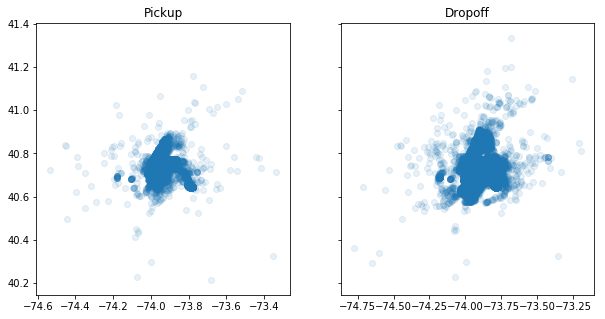

In [18]:
# Plot locations - look for outliers
n = 300000  # number of data points to display
 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude[:n],
            train.pickup_latitude[:n],
            alpha=0.1)
ax1.set_title('Pickup')
ax2.scatter(train.dropoff_longitude[:n],
            train.dropoff_latitude[:n],
            alpha=0.1)
ax2.set_title('Dropoff')

plt.show()

In [14]:
# The values are not too wild, but we'll trim them back a little to be conservative
print(train.pickup_latitude.max())
print(train.pickup_latitude.min())
print(train.pickup_longitude.max())
print(train.pickup_longitude.min())
print()
print(train.dropoff_latitude.max())
print(train.dropoff_latitude.min())
print(train.dropoff_longitude.max())
print(train.dropoff_longitude.min())

51.88108444213867
34.359695434570305
-61.33552932739258
-121.93334197998048

43.92102813720703
32.1811408996582
-61.33552932739258
-121.9333038330078


In [15]:
# Find limits of location
max_value = 99.999
min_value = 0.001
 
max_pickup_lat = np.percentile(train.pickup_latitude, max_value)
min_pickup_lat = np.percentile(train.pickup_latitude, min_value)
max_pickup_long = np.percentile(train.pickup_longitude, max_value)
min_pickup_long = np.percentile(train.pickup_longitude, min_value)
 
max_dropoff_lat = np.percentile(train.dropoff_latitude, max_value)
min_dropoff_lat = np.percentile(train.dropoff_latitude, min_value)
max_dropoff_long = np.percentile(train.dropoff_longitude, max_value)
min_dropoff_long = np.percentile(train.dropoff_longitude, min_value)

In [16]:
# Remove extreme values
train = train[(train.pickup_latitude <= max_pickup_lat) & (train.pickup_latitude >= min_pickup_lat)]
train = train[(train.pickup_longitude <= max_pickup_long) & (train.pickup_longitude >= min_pickup_long)]
 
train = train[(train.dropoff_latitude <= max_dropoff_lat) & (train.dropoff_latitude >= min_dropoff_lat)]
train = train[(train.dropoff_longitude <= max_dropoff_long) & (train.dropoff_longitude >= min_dropoff_long)]

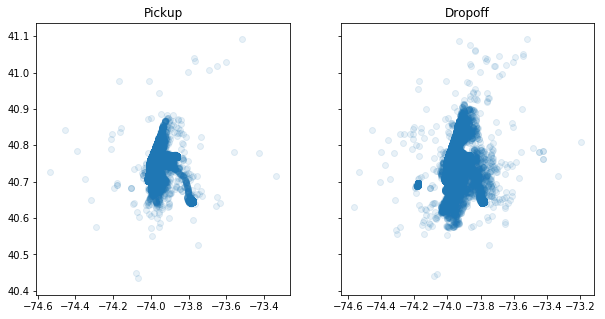

In [17]:
# Replot to see the differences - minimal, but there is some change
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude[:n],
            train.pickup_latitude[:n],
            alpha=0.1)
ax1.set_title('Pickup')
ax2.scatter(train.dropoff_longitude[:n],
            train.dropoff_latitude[:n],
            alpha=0.1)
ax2.set_title('Dropoff')

plt.show()

In [20]:
df = pd.concat([train, test])
print(df.isnull().sum())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [21]:
print('=============')
print(train.pickup_datetime.max())
print(train.pickup_datetime.min())
print()
print(test.pickup_datetime.max())
print(test.pickup_datetime.min())
print()
print(df.pickup_datetime.max())
print(df.pickup_datetime.min())

2016-06-30 23:59:39
2016-01-01 00:00:17

2016-06-30 23:59:58
2016-01-01 00:00:22

2016-06-30 23:59:58
2016-01-01 00:00:17


In [22]:
# Convert to datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
# Calculate what minute in a day the pickup is at
df['pickup_minute_of_the_day'] = df.pickup_datetime.dt.hour * 60 + df.pickup_datetime.dt.minute

In [23]:
kmeans_pickup_time = KMeans(n_clusters=24, random_state=2).fit(df.pickup_minute_of_the_day[:500000].values.reshape(-1, 1))
 
df['kmeans_pickup_time'] = kmeans_pickup_time.predict(df.pickup_minute_of_the_day.values.reshape(-1, 1))

Text(0.5,1,'Pickup Hour')

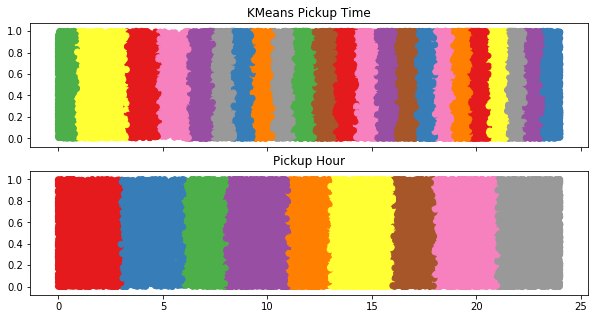

In [24]:
# Compare the distribution of kmeans_pickup_time and the standard 24 hour breakdown
n = 50000  # number of data points to plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
 
ax1.scatter(x=df.pickup_minute_of_the_day[:n] / 60,
            y=np.random.uniform(0, 1, n),
            cmap='Set1',
            c=df.kmeans_pickup_time[:n])
ax1.set_title('KMeans Pickup Time')
 
ax2.scatter(x=df.pickup_minute_of_the_day[:n] / 60,
            y=np.random.uniform(0, 1, n),
            cmap='Set1',
            c=df.pickup_datetime.dt.hour[:n])
ax2.set_title('Pickup Hour')

plt.show()

In [26]:
# Load a list of holidays in the US
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# Load business days
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start=df.pickup_datetime.min(),
                                 end=df.pickup_datetime.max(),
                                 freq=us_bd)
business_days = pd.to_datetime(business_days).date

# Create features relating to time
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_weekday'] = df.pickup_datetime.dt.weekday
df['pickup_is_weekend'] = df.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
df['pickup_holiday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays)
df['pickup_holiday'] = df.pickup_holiday.map(lambda x: 1 if x == True else 0)
 
# If day is before or after a holiday
df['pickup_near_holiday'] = (pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | 
                             pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
df['pickup_near_holiday'] = df.pickup_near_holiday.map(lambda x: 1 if x == True else 0)
df['pickup_businessday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(business_days)
df['pickup_businessday'] = df.pickup_businessday.map(lambda x: 1 if x == True else 0)

In [27]:
# Calculates what minute of the week it is
df['week_delta'] = (df.pickup_weekday + ((df.pickup_datetime.dt.hour + 
                                              (df.pickup_datetime.dt.minute / 60.0)) / 24.0))

In [28]:
# Determines number of rides that occur during each specific time
# Should help to determine traffic
ride_counts = df.groupby(['pickup_month', 'pickup_weekday', 'pickup_holiday', 'pickup_near_holiday',
            'pickup_businessday', 'kmeans_pickup_time']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0, 1)
 
# Add `ride_counts` to dataframe
df = df.merge(ride_counts, on=['pickup_month',
                          'pickup_weekday',
                          'pickup_holiday',
                          'pickup_near_holiday',
                          'pickup_businessday',
                          'kmeans_pickup_time'], how='left')
# Dont' need this feature any more
df = df.drop('pickup_datetime', 1)

Text(0.5,1,'Dropoff')

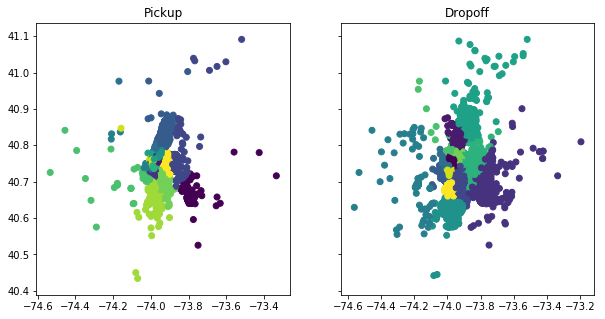

In [30]:
# Process the geographic location
kmeans_pickup = KMeans(n_clusters=15, random_state=2).fit(df[['pickup_latitude', 'pickup_longitude']][:500000])
kmeans_dropoff = KMeans(n_clusters=15, random_state=2).fit(df[['dropoff_latitude', 'dropoff_longitude']][:500000])
 
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude', 'pickup_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude', 'dropoff_longitude']])

# Plot these 15 groups
 
n = 100000  # Number of data points to plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n],
            df.pickup_latitude[:n],
            cmap='viridis',
            c=df.kmeans_pickup[:n])
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n],
            df.dropoff_latitude[:n],
            cmap='viridis',
            c=df.kmeans_dropoff[:n])
ax2.set_title('Dropoff')
# plt.show()

In [31]:
# Reduce pickup and dropoff locations to one value
pca = PCA(n_components=1)
df['pickup_pca'] = pca.fit_transform(df[['pickup_latitude', 'pickup_longitude']])
df['dropoff_pca'] = pca.fit_transform(df[['dropoff_latitude', 'dropoff_longitude']])

In [32]:
# Create distance features
df['distance'] = np.sqrt(np.power(df['dropoff_longitude'] - df['pickup_longitude'], 2) + 
                         np.power(df['dropoff_latitude'] - df['pickup_latitude'], 2))
df['haversine_distance'] = df.apply(lambda r: haversine.haversine((r['pickup_latitude'], r['pickup_longitude']),
                                                                  (r['dropoff_latitude'], r['dropoff_longitude'])),
                           axis=1)
df['manhattan_distance'] = (abs(df.dropoff_longitude - df.pickup_longitude) + 
                            abs(df.dropoff_latitude - df.pickup_latitude))
df['log_distance'] = np.log(df['distance'] + 1)
df['log_haversine_distance'] = np.log(df['haversine_distance'] + 1)
df['log_manhattan_distance'] = np.log(df.manhattan_distance + 1)

def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))


df['bearing'] = calculate_bearing(df.pickup_latitude,
                                  df.pickup_longitude,
                                  df.dropoff_latitude,
                                  df.dropoff_longitude)

In [33]:
# Group passenger_count by type of group
df['no_passengers'] = df.passenger_count.map(lambda x: 1 if x == 0 else 0)
df['one_passenger'] = df.passenger_count.map(lambda x: 1 if x == 1 else 0)
df['few_passengers'] = df.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
df['many_passengers'] = df.passenger_count.map(lambda x: 1 if x >= 5 else 0)
df.store_and_fwd_flag = df.store_and_fwd_flag.map(lambda x: 1 if x == 'Y' else 0)

In [34]:
# Create dummy features for these features, then drop these features
dummies = ['kmeans_pickup_time', 'pickup_month', 'pickup_weekday', 'kmeans_pickup', 'kmeans_dropoff']
for feature in dummies:
    dummy_features = pd.get_dummies(df[feature], prefix=feature)
    for dummy in dummy_features:
        df[dummy] = dummy_features[dummy]
    df = df.drop([feature], 1)

# Don't need this feature any more
df = df.drop(['id'], 1)


# Transform each feature to have a mean of 0 and standard deviation of 1
# Help to train the neural network
for feature in df:
    if feature == 'trip_duration':
        continue
    mean, std = df[feature].mean(), df[feature].std()
    df.loc[:, feature] = (df[feature] - mean) / std

In [35]:
# Return data into a training and testing set
trainFinal = df[:-len(test)]
testFinal = df[-len(test):]
testFinal = testFinal.drop('trip_duration', 1)

# Save final train/test data set
trainFinal.to_csv('train.csv', index=False)
testFinal.to_csv('test.csv', index=False)

In [41]:
# Data partitioning
from sklearn.model_selection import train_test_split

train, valid = train_test_split(trainFinal, test_size=0.3)

# Save these data
train.to_csv('taxi_train.csv', index=False)
valid.to_csv('taxi_validation.csv', index=False)